In [ ]:
# |default_exp topic_segmentation
# |default_cls_lvl 3

In [ ]:
# |hide
%reload_ext autoreload
%autoreload 2

# topic_segmentation

Training, saving, and tuning code for building topic segmentation model(s) that can predict where new topics begin given a transcript (e.g. rows of duration and text)

In [ ]:
# |export
from __future__ import annotations

import ast, os, gc, random, time

from dotenv import load_dotenv
from fastai.callback.all import *
from fastai.callback.wandb import *
from fastai.data.block import CategoryBlock, ColReader, ColSplitter, DataBlock, IndexSplitter, RegressionBlock
from fastai.imports import *
from fastai.layers import SigmoidRange
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat, MSELossFlat, LabelSmoothingCrossEntropyFlat
from fastai.optimizer import Adam
from fastai.metrics import *
from fastai.torch_core import *
from fastai.torch_imports import *
from fastcore.transform import Transform
import optuna
from optuna.integration.fastaiv2 import FastAIPruningCallback
from optuna.integration.wandb import WeightsAndBiasesCallback
import segeval
from sklearn.metrics import mean_absolute_error, f1_score, recall_score, precision_score, fbeta_score
from sklearn.model_selection import train_test_split
import statistics
from torch.utils.checkpoint import checkpoint
from transformers import (
    AutoConfig,
    AutoModelForNextSentencePrediction,
    AutoModelForSequenceClassification,
    DebertaV2Model,
    logging as hf_logging,
)
from transformers.models.deberta_v2.modeling_deberta_v2 import ContextPooler
from transformers.models.deberta_v2.modeling_deberta_v2 import StableDropout
import wandb

from blurr.callbacks import GradientCheckpointing
from blurr.text.data.core import TextBlock, BatchTokenizeTransform, first_blurr_tfm
from blurr.text.modeling.core import BaseModelWrapper, BaseModelCallback, blurr_splitter
from blurr.text.utils import get_hf_objects
from blurr.utils import PreCalculatedCrossEntropyLoss, PreCalculatedMSELoss, set_seed

from course_copilot import preprocessing, training, utils

In [ ]:
# | hide
import pdb

from fastcore.test import *
import nbdev

from blurr.utils import print_versions

In [ ]:
# |export
# silence all the HF warnings and load environment variables
warnings.simplefilter("ignore")
hf_logging.set_verbosity_error()

load_dotenv()

True

In [ ]:
# | echo: false
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions("torch fastai transformers")

What we're running with at the time this documentation was generated:
torch: 1.12.1+cu102
fastai: 2.7.9
transformers: 4.22.0


In [ ]:
# |hide
# |cuda
torch.cuda.set_device(1)
print(f"Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}")

Using GPU #1: GeForce GTX 1080 Ti


## Configuration

In [ ]:
print(os.environ["WANDB_PROJECT_NAME"])
print(os.environ["WANDB_TEAM"])

course-copilot-ml
course-copilot


In [ ]:
# | export
class TopicSegmentationConfig(training.TrainConfig):
    """A 'training.Config' object training and tuning our segmentation models. Uses fastai and huggingface defaults by default"""

    # huggingface objects
    hf_model_cls = AutoModelForSequenceClassification
    hf_model_checkpoint = "microsoft/deberta-v3-small"
    hf_config_kwargs = {"num_labels": 2}
    hf_tokenizer_kwargs = {}
    new_special_tokens = None
    hf_model_kwargs = {}

    # datablock/dataloaders
    use_next_pos_prob = 0.75
    use_adjacent_neg_prob = 0.5
    max_length = True
    lower_case = True
    truncation_strategy = True
    include_labels = False
    tok_kwargs = {}
    batch_size = 8
    accum = None

    # learner
    custom_model_kwargs = {"p": 0.1, "dropout_cls": nn.Dropout}
    include_gradient_checkpointing = False
    one_cycle_moms_start = 0.8
    one_cycle_moms_min = 0.7
    one_cycle_moms_end = 0.8
    adam_beta2 = 0.99
    adam_eps = 1e-7
    weight_decay = 0.0
    max_grad_norm = None
    save_best_model = True
    use_fp16 = True

    # training
    n_frozen_epochs = 0
    frozen_lr = 0
    n_unfrozen_epochs = 4
    unfrozen_lr_min = 1e-5
    unfrozen_lr_max = 1e-3

In [ ]:
class ExampleCFG(TopicSegmentationConfig):
    training_subset = 0.25
    n_frozen_epochs = 0
    n_unfrozen_epochs = 2

In [ ]:
[f"{k}: {v}" for k, v in training.get_train_config_props(ExampleCFG).items()][:5]

['accum: None',
 'adam_beta2: 0.99',
 'adam_eps: 1e-07',
 'batch_size: 8',
 "custom_model_kwargs: {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}"]

## Data

In [ ]:
# | export
def _get_training_data(cfg: TopicSegmentationConfig, data_dir="data", on_the_fly=False, split_type="cross_validation"):
    if on_the_fly:
        raw_train_df, _ = preprocessing.preprocess_data(
            ds="train", data_path=data_dir, return_file=True, save_file=False
        )
    else:
        raw_train_df = pd.read_csv(f"{data_dir}/clean/segmentation_train.csv", index_col=None)

    raw_train_df["other_topic_seqs"] = raw_train_df["other_topic_seqs"].apply(ast.literal_eval)
    raw_train_df.reset_index(inplace=True)

    # for training we need to remove sequences for which there is not a "next_seq" (e.g., we are at end of a topic)
    train_df = raw_train_df[raw_train_df["is_topic_end"] == False].copy()

    train_df = train_df.sample(frac=cfg.training_subset, random_state=cfg.random_seed).reset_index(drop=True)

    if split_type == "cross_validation":
        courses = train_df["course_title"].unique()
        np.random.seed(cfg.random_seed)
        np.random.shuffle(courses)

        val_sz = int(len(courses) * cfg.val_pct)
        val_courses = courses[:val_sz]

        is_val = np.isin(train_df["course_title"], val_courses)

        idxs = np.arange(len(train_df))
        val_idxs = idxs[is_val]
        trn_idxs = idxs[~is_val]

        return train_df.copy(), trn_idxs, val_idxs, raw_train_df.copy()
    else:
        raise NotImplementedError()

In [ ]:
train_df, trn_idxs, val_idxs, raw_train_df = _get_training_data(
    ExampleCFG, data_dir="../data", on_the_fly=False, split_type="cross_validation"
)

In [ ]:
print(len(train_df))
print(len(trn_idxs), len(val_idxs))
train_df.head(2)

6196
4981 1215


,index,course_title,lesson_num,topic,seq,prev_seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs
0,23538,parker - learn photography,1,Apertures Deep Dive,particular the detroit tigers so their wedding day was in that area,and if you recognize this letter d you know that's from detroit and in,and we were near the detroit tiger stadium if i had completely blurred out,False,NaN,"[you fully understand how they work and how they can alter your final image now previously i demonstrated that the, larger the aperture the more the background is blurred out when it comes to the area in focus this is referred to, as the depth of field so the depth of field is the zone within a photo that, appears sharp and in focus when focusing on your subject that is considered the point of focus beyond that, how much appears in focus corresponds to the depth of field so here are two more, images and the amount of the depth of field in one is greater than the other, the first image i ca..."
1,6466,Full Stack Deep Learning - Spring 2021,9,Long Term Ethical Problems in AI,we basically need robots in order to have a functioning economy in the next few decades,brilliant person and this article which i recommend you click on talks about how,an interesting spin on this worry though is ai not necessarily replacing human labor,False,NaN,"[a.i so the first i think a lot of people's minds go to autonomous weapons and maybe they go into a place that, is a little easy to dismiss as maybe far-fetched not realistic we don't have to worry about it it's just a movie, but of course as the saying goes the future is already here it's just not evenly distributed so, israel apparently has autonomous robo snipers on their borders today and just, i think last weekend or something there was an article about the new york city police deploying, the boston dynamics spot robot which actually anyone can buy now i think it's only like, 60 000 o..."


## Hugging Face `transformers` objects

In [ ]:
# | export
def _get_task_hf_objects(cfg: TopicSegmentationConfig):
    # if 'only_seed_splits' = True, then we only care about reproducibility insofar as the training and
    # validation sets go
    if cfg.random_seed and not cfg.only_seed_splits:
        set_seed(cfg.random_seed)

    # need to create configuration object separately because we may be adding new attributes (e.g., cls_dropout)
    hf_config = AutoConfig.from_pretrained(cfg.hf_model_checkpoint)
    hf_config.update(cfg.hf_config_kwargs)

    hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(
        cfg.hf_model_checkpoint,
        model_cls=cfg.hf_model_cls,
        config=hf_config,
        tokenizer_kwargs=cfg.hf_tokenizer_kwargs,
        model_kwargs=cfg.hf_model_kwargs,
    )

    if cfg.new_special_tokens:
        # After adding the new tokens, we need to resize the embedding matrix in the model and initialize the weights
        hf_tokenizer.add_special_tokens({"additional_special_tokens": cfg.new_special_tokens})
        hf_model.resize_token_embeddings(len(hf_tokenizer))

        with torch.no_grad():
            emb_size = hf_model.config.to_dict().get("embedding_size", hf_model.config.hidden_size)
            hf_model.get_input_embeddings().weight[-len(hf_tokenizer), :] = torch.zeros([emb_size])

    return hf_arch, hf_config, hf_tokenizer, hf_model

In [ ]:
hf_arch, hf_config, hf_tokenizer, hf_model = _get_task_hf_objects(ExampleCFG)

## `DataLoaders`

In [ ]:
# | export
def _build_pos_inputs(example, cfg: TopicSegmentationConfig, hf_tokenizer_sep_token="[SEP]"):
    seq_text = example["seq"].strip().lower() if cfg.lower_case else example["seq"].strip()
    next_seq_text = example["next_seq"].strip().lower() if cfg.lower_case else example["next_seq"].strip()

    non_adjacent_text = (
        random.choice(example["other_topic_seqs"]).strip() if len(example["other_topic_seqs"]) > 0 else None
    )
    if cfg.lower_case and non_adjacent_text:
        non_adjacent_text = non_adjacent_text.lower()

    if example["is_topic_end"] and example["next_topic_begin_seq"] and non_adjacent_text:
        # this is the last sequence in the topic so the only thing that will work here is to pair it with another non-adjacent seq in the same topic
        # and therefore we just duplicate it here.
        next_topic_begin_seq = (
            example["next_topic_begin_seq"].strip().lower()
            if cfg.lower_case
            else example["next_topic_begin_seq"].strip()
        )
        inp = (
            f"{seq_text}{hf_tokenizer_sep_token}{non_adjacent_text}",
            f"{seq_text}{hf_tokenizer_sep_token}{non_adjacent_text}",
        )
    else:
        # the positive pair will be a seq + the next seq -or- the seq + a non-adjacent seq in the same topic
        inp = (
            f"{seq_text}{hf_tokenizer_sep_token}{next_seq_text}",
            f"{seq_text}{hf_tokenizer_sep_token}{non_adjacent_text}" if non_adjacent_text else "xxNONExx",
        )

    return inp

In [ ]:
# | export
def _build_neg_inputs(example, cfg: TopicSegmentationConfig, hf_tokenizer_sep_token="[SEP]", df=None):
    seq_text = example["seq"].strip()

    # if at the last sequence for a topic, set the negative pair = seq + first sequence in next topic,
    # else get a sequence that is not adjacent but in same topic
    if example["is_topic_end"] and example["next_topic_begin_seq"]:
        neg_seq_non_adjacent_text = example["next_topic_begin_seq"].strip()
    elif len(example["other_topic_seqs"]) > 0:
        neg_seq_non_adjacent_text = random.choice(example["other_topic_seqs"]).strip()
    else:
        neg_seq_non_adjacent_text = "xxNONExx"

    # get a sequence that is in an entirely different topic
    # option 1: can be in same lesson but different topic or in a different course entirely
    # neg_seq_other_topic_text = (
    #     df["seq"][
    #         (df["course_title"] != example["course_title"]) | (df["lesson_num"] != example["lesson_num"])
    #     ]
    #     .sample(n=1)
    #     .values[0]
    #     .strip()
    # )

    # option 2: sample from a different course entirely
    neg_seq_other_topic_text = df["seq"][(df["course_title"] != example["course_title"])].sample(n=1).values[0].strip()

    if cfg.lower_case:
        seq_text = seq_text.lower()
        neg_seq_non_adjacent_text = neg_seq_non_adjacent_text.lower()
        neg_seq_other_topic_text = neg_seq_other_topic_text.lower()

    # our SiameseBatchTokenizeTransform will choose which one to use each time the item is fetched
    inp = (
        f"{seq_text}{hf_tokenizer_sep_token}{neg_seq_non_adjacent_text}",
        f"{seq_text}{hf_tokenizer_sep_token}{neg_seq_other_topic_text}",
    )

    return inp

In [ ]:
# | export
def _build_targets(example):
    return 0

In [ ]:
# | export
class SiameseBatchTokenizeTransform(BatchTokenizeTransform):
    def __init__(self, use_next_pos_prob=0.75, use_adjacent_neg_prob=0.5, **kwargs):
        super().__init__(**kwargs)
        self.use_next_pos_prob = use_next_pos_prob
        self.use_adjacent_neg_prob = use_adjacent_neg_prob

    def encodes(self, samples, return_batch_encoding=False):
        # our positive example
        pos_ex_idx = 0 if random.uniform(0, 1) < self.use_next_pos_prob else 1
        updated_samples1, inputs1 = super().encodes(
            [(s[0][pos_ex_idx] if s[0][pos_ex_idx] != "xxNONExx" else s[0][0], *s[2:], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # our negative example (sometimes the adjacent will be ""; if that is the case use the other topic negative example which is at idx=1)
        neg_ex_idx = 0 if random.uniform(0, 1) < self.use_adjacent_neg_prob and pos_ex_idx == 0 else 1
        updated_samples2, inputs2 = super().encodes(
            [(s[1][neg_ex_idx] if s[1][neg_ex_idx] != "xxNONExx" else s[1][1], *s[2:]) for s in samples],
            return_batch_encoding=True,
        )

        # if there are no targets (e.g., when used for inference)
        if len(samples[0]) == 2:
            return [(inps1[0], inps2[0]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

        return [(inps1[0], inps2[0], inps1[-1]) for inps1, inps2 in zip(updated_samples1, updated_samples2)]

In [ ]:
# | export
def _get_dls(cfg: TopicSegmentationConfig, df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs_or_fold):
    # define validation set
    if isinstance(val_idxs_or_fold, int):
        df["is_valid"] = df["k_fold"] == val_idxs_or_fold
        splitter = ColSplitter()
    else:
        splitter = IndexSplitter(val_idxs_or_fold)

    if cfg.random_seed:
        set_seed(cfg.random_seed)

    batch_tokenize_tfm = SiameseBatchTokenizeTransform(
        use_next_pos_prob=cfg.use_next_pos_prob,
        use_adjacent_neg_prob=cfg.use_adjacent_neg_prob,
        hf_arch=hf_arch,
        hf_config=hf_config,
        hf_tokenizer=hf_tokenizer,
        hf_model=hf_model,
        include_labels=cfg.include_labels,
        max_length=cfg.max_length,
        truncation=cfg.truncation_strategy,
        tok_kwargs=cfg.tok_kwargs,
    )

    blocks = (TextBlock(batch_tokenize_tfm=batch_tokenize_tfm), noop, CategoryBlock)

    get_pos_x = partial(_build_pos_inputs, cfg=cfg, hf_tokenizer_sep_token=hf_tokenizer.sep_token)
    get_neg_x = partial(_build_neg_inputs, cfg=cfg, hf_tokenizer_sep_token=hf_tokenizer.sep_token, df=df)
    get_y = partial(_build_targets)

    dblock = DataBlock(
        blocks=blocks,
        get_x=[get_pos_x, get_neg_x],
        get_y=get_y,
        splitter=splitter,
        n_inp=2,
    )

    if cfg.random_seed:
        set_seed(cfg.random_seed)

    bsz = cfg.batch_size if cfg.accum is None else cfg.batch_size // cfg.accum
    return dblock.dataloaders(df, bs=bsz, val_bs=bsz * 2)

In [ ]:
dls = _get_dls(ExampleCFG, train_df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs_or_fold=val_idxs)

In [ ]:
b = dls.one_batch()
print(len(b))
print("")
print(hf_tokenizer.decode(b[0]["input_ids"][0]))
print("")
print(hf_tokenizer.decode(b[1]["input_ids"][0]))
print("")
print(b[2])

3

[CLS] of three of them so, you know, you kind of... this is the idea, right?, as if somebody says to you: “i like this movie, this movie, this movie” and you're like: “oh, they like those movies too” what[SEP] other movies do you like? and they'll say: “oh, how about this?” there's a chance, good chance, that you're going to like the same thing. that's the basis of collaborative filtering, okay, it's...[SEP]

[CLS] of three of them so, you know, you kind of... this is the idea, right?, as if somebody says to you: “i like this movie, this movie, this movie” and you're like: “oh, they like those movies too” what[SEP] you're going to be really hungry and[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:1')


## Models

In [ ]:
# | export
def blurr_splitter_with_head(m: Module):
    """Simply adds an additional layer group to the classification head"""
    base_param_groups = blurr_splitter(m)

    added_groups = L([m for m_name, m in list(m.named_children()) if m_name != "hf_model"])
    added_param_groups = added_groups.map(params).filter(lambda el: len(el) > 0)

    return base_param_groups + added_param_groups


def blurr_splitter_on_backbone(m: Module):
    """Creates two layer groups: One for the backbone and one for the pooler/classification head"""
    root_modules = list(m.named_children())
    top_module_name, top_module = root_modules[0]

    groups = L(top_module)
    groups += L([m for m_name, m in root_modules[1:]])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
# | export
# TODO: Review PyTorch docs (https://pytorch.org/docs/stable/generated/torch.nn.MarginRankingLoss.html); consider changing
def MarginRankingLoss(pos_neg_scores, targs):
    margin = 1
    p_scores, n_scores = pos_neg_scores

    scores = margin - p_scores + n_scores
    scores = scores.clamp(min=0)
    return scores.mean()

In [ ]:
# | export
def topic_seg_f1_score(inps, targs):
    labels = []
    all_pos_scores, all_neg_scores = inps[0], inps[1]

    for i in range(len(all_pos_scores)):
        if all_pos_scores[i] > all_neg_scores[i]:
            labels.append(1)
        else:
            labels.append(0)

    return sum(labels) / float(len(all_pos_scores))


_topic_seg_f1_score = AvgMetric(topic_seg_f1_score)

In [ ]:
# | export
class TopicSegmentationModelWrapper(BaseModelWrapper):
    def __init__(
        self,
        hf_config,
        hf_model,
        dropout_cls=nn.Dropout,
        p=0.1,
        hf_model_kwargs={},
    ):
        super().__init__(hf_model=hf_model, output_hidden_states=True, hf_model_kwargs=hf_model_kwargs)
        store_attr()

        self.coherence_prediction_dec = nn.Sequential(
            *[
                nn.Linear(hf_config.hidden_size, hf_config.hidden_size),
                nn.ReLU(),
                dropout_cls(p=p),
                nn.Linear(hf_config.hidden_size, 2),
            ]
        )

    def forward(self, inputs1, inputs2):
        # sequence 1 (pos examples)
        inputs1_res = super().forward(inputs1)
        pos_scores = inputs1_res.hidden_states[-1][:, 0, :]
        pos_scores = self.coherence_prediction_dec(pos_scores)

        # sequence 2 (neg examples)
        inputs2_res = super().forward(inputs2)
        neg_scores = inputs2_res.hidden_states[-1][:, 0, :]
        neg_scores = self.coherence_prediction_dec(neg_scores)

        return pos_scores[:, 0], neg_scores[:, 0]

## `Learner`

In [ ]:
# | export
def _get_learner(cfg: TopicSegmentationConfig, dls, hf_config, hf_model, learner_path="."):

    if cfg.random_seed and not cfg.only_seed_splits:
        set_seed(cfg.random_seed)

    learn_cbs = []
    if cfg.accum is not None:
        learn_cbs.append(GradientAccumulation(cfg.batch_size))

    blurr_model_wrapper = TopicSegmentationModelWrapper(
        hf_config=hf_config, hf_model=hf_model, **cfg.custom_model_kwargs
    )

    learn = Learner(
        dls,
        blurr_model_wrapper,
        model_dir=learner_path,
        opt_func=partial(Adam, sqr_mom=cfg.adam_beta2, eps=cfg.adam_eps, wd=cfg.weight_decay),
        moms=(cfg.one_cycle_moms_start, cfg.one_cycle_moms_min, cfg.one_cycle_moms_end),
        loss_func=PreCalculatedCrossEntropyLoss() if cfg.include_labels else MarginRankingLoss,
        metrics=[topic_seg_f1_score],
        cbs=learn_cbs,
        splitter=blurr_splitter_on_backbone,
    )

    learn.create_opt()
    learn.freeze()

    if cfg.use_fp16:
        learn = learn.to_fp16()

    return learn

In [ ]:
learn = _get_learner(cfg=ExampleCFG, dls=dls, hf_config=hf_config, hf_model=hf_model, learner_path="../models")

fit_cbs = []
if ExampleCFG.max_grad_norm:
    fit_cbs.append(GradientClip(max_norm=ExampleCFG.max_grad_norm))

if ExampleCFG.include_gradient_checkpointing:
    fit_cbs.append(GradientCheckpointing())

if ExampleCFG.save_best_model:
    fit_cbs.append(
        SaveModelCallback(
            monitor="valid_loss",
            comp=np.less,
            fname=f"temp_best_loss_topic_segmentation",
            reset_on_fit=False,
        )
    )

In [ ]:
print(len(learn.opt.param_groups))

2


In [ ]:
# learn.unfreeze()
# learn.summary()

SuggestedLRs(minimum=1.0964781722577755e-07, steep=0.005248074419796467, valley=0.00013182566908653826, slide=0.0014454397605732083)

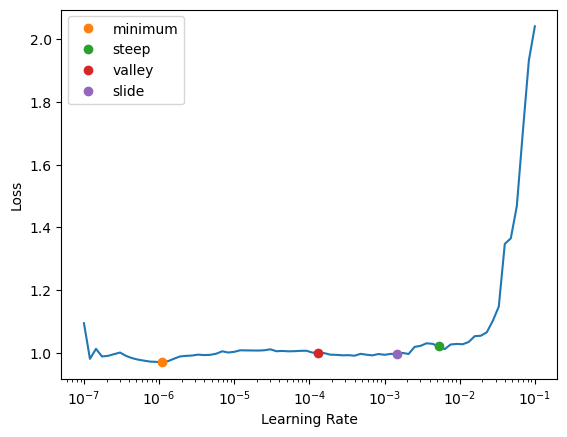

In [ ]:
learn.unfreeze()
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
if ExampleCFG.random_seed:
    set_seed(ExampleCFG.random_seed)

learn.fit_one_cycle(2, slice(1e-5, 1e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.456956,0.556683,0.781070,01:25
1,0.335876,0.568177,0.772840,01:25


Better model found at epoch 0 with valid_loss value: 0.5566829442977905.


In [ ]:
[f"{k}: {v}" for k, v in training.get_train_config_props(ExampleCFG).items()][:5]

['accum: None',
 'adam_beta2: 0.99',
 'adam_eps: 1e-07',
 'batch_size: 8',
 "custom_model_kwargs: {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}"]

In [ ]:
for m_name, m_val in zip(learn.recorder.metric_names[1:-1], learn.recorder.final_record):
    print(m_name, m_val)

train_loss 0.33587607741355896
valid_loss 0.5681771039962769
topic_seg_f1_score 0.7728395061728395


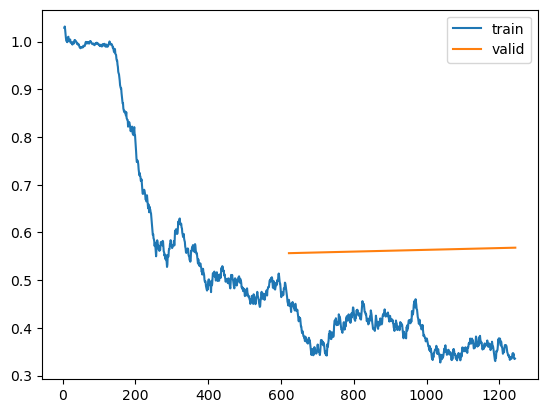

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.export("../models/test_topic_segmentation.pkl")

## Validation

In [ ]:
# | export
def depth_score_cal(scores):
    output_scores = []
    for i in range(len(scores)):
        lflag = scores[i]
        rflag = scores[i]
        if i == 0:
            hl = scores[i]
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
        elif i == len(scores):
            hr = scores[i]
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        else:
            for r in range(i + 1, len(scores)):
                if rflag <= scores[r]:
                    rflag = scores[r]
                else:
                    break
            for l in range(i - 1, -1, -1):
                if lflag <= scores[l]:
                    lflag = scores[l]
                else:
                    break
        depth_score = 0.5 * (lflag + rflag - 2 * scores[i])
        output_scores.append(depth_score)

    return output_scores

In [ ]:
# | export
def _get_validation_preds(
    hf_model, hf_tokenizer, val_df, val_course_titles, batch_size=16, threshold_std_coeff=1.0, verbose=False
):
    hf_model.eval()

    if verbose:
        print(f"Getting predictions for validatation set ...")

    val_results = []
    for ct in val_course_titles:
        for ln in val_df[val_df["course_title"] == ct]["lesson_num"].unique().tolist():
            inf_df = val_df[(val_df["course_title"] == ct) & (val_df["lesson_num"] == ln)].copy()
            inf_df.reset_index(inplace=True)

            if verbose:
                print(f"processing {ct}: {ln}")

            # gather sequence pairs
            seq_pairs = L()
            for i in range(len(inf_df) - 1):
                seq_a = inf_df.iloc[i]["seq"].strip().lower()
                seq_b = inf_df.iloc[i + 1]["seq"].strip().lower()

                seq_pairs.append((seq_a, seq_b))

            # score sequence pairs
            scores = []
            for i in range(0, len(seq_pairs), batch_size):
                # print(i)
                batch = seq_pairs[i : i + batch_size]
                inputs = hf_tokenizer(
                    list(batch.itemgot(0)), list(batch.itemgot(1)), padding=True, max_length=True, return_tensors="pt"
                ).to(hf_model.device)

                batch_scores = hf_model(**inputs)
                scores += batch_scores[0][:, 0].detach().cpu()[:, None]

            scores = torch.sigmoid(torch.concat(scores)).numpy().tolist()

            # calculate depth_scores
            depth_scores = depth_score_cal(scores)
            threshold = sum(depth_scores) / (len(depth_scores)) + (statistics.stdev(depth_scores) * threshold_std_coeff)

            # calculate reference (target) topics and count of sequences in each
            # seg_r_labels = reference beginning of new topic
            # seg_r = # of sequences in each reference topic
            seg_r_labels = []
            seg_r = []
            tmp = 1

            for r_idx, r in inf_df.iterrows():
                current_topic = r["topic"]
                if r_idx == 0:
                    last_seen_topic = r["topic"]

                if last_seen_topic != current_topic:
                    last_seen_topic = current_topic
                    seg_r_labels.append(1)
                    seg_r.append(tmp)
                    tmp = 1
                else:
                    seg_r_labels.append(0)
                    tmp += 1 if r_idx != 0 else 0

            seg_r.append(tmp)

            # seg_p_labels = predicted beginning of new topic
            # seg_p = # of sequences in each predicted topic

            # we add 1 in here to compensate for lopping off the last sequence (which we do cuz it has no next_seq to pair with)
            # default everything to 0
            seg_p_labels = [0] * (len(depth_scores) + 1)

            # loop thru `depth_scores`, if any > threshold mark them as a boundary (beginning of a new topic) and then update `seg_p_labels`
            boundary_idxs = []
            for i in range(len(depth_scores)):
                if depth_scores[i] > threshold:
                    boundary_idxs.append(i)

            for i in boundary_idxs:
                seg_p_labels[i] = 1

            tmp = 0
            seg_p = []
            for idx, is_beg_topic in enumerate(seg_p_labels):
                if is_beg_topic == 1 and idx != 0:
                    # tmp += 1
                    seg_p.append(tmp)
                    tmp = 1
                else:
                    tmp += 1

            seg_p.append(tmp)

            seg_idxs = [seg_idx for seg_idx, v in enumerate(seg_p_labels) if v == 1 or seg_idx == 0]
            inf_df["depth_score"] = depth_scores + [None]
            inf_df["threshold"] = threshold
            inf_df["pred_start"] = False
            inf_df.loc[seg_idxs, "pred_start"] = True

            val_results.append(inf_df)

    return pd.concat(val_results)

In [ ]:
val_course_titles = train_df.iloc[val_idxs]["course_title"].unique().tolist()
preds_df = _get_validation_preds(
    hf_model,
    hf_tokenizer,
    raw_train_df,
    val_course_titles[:2],
    batch_size=16,
    threshold_std_coeff=1.0,
)

print(len(preds_df))
preds_df.head()

4628


,level_0,index,course_title,lesson_num,topic,seq,prev_seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs,depth_score,threshold,pred_start
0,19012,19012,markowskyart - begginer drawing course,1,Introduction,okay here we are welcome everybody wherever you are here on planet Earth,xxBEGIN_TOPICxx,I'm welcoming you into my studio here in Vancouver British Columbia Canada my,False,NaN,"[name is Michael Markowski and I'm gonna be your drawing instructor for the next, hour or month depending on how many classes you decide to watch so it's, really exciting that there's I see 50 people who are watching right now which is really exciting to have a nice big, audience worth of people and I don't know how many comments have been pouring in here I was looking at a few of those, right started and people from a lot of people from British Columbia and it's great also to see a bunch of people who, have taken classes with me in the past so I guess that might mean I'm possibly, have do...",0.001695,0.00322,True
1,19013,19013,markowskyart - begginer drawing course,1,Introduction,I'm welcoming you into my studio here in Vancouver British Columbia Canada my,okay here we are welcome everybody wherever you are here on planet Earth,name is Michael Markowski and I'm gonna be your drawing instructor for the next,False,NaN,"[okay here we are welcome everybody wherever you are here on planet Earth, hour or month depending on how many classes you decide to watch so it's, really exciting that there's I see 50 people who are watching right now which is really exciting to have a nice big, audience worth of people and I don't know how many comments have been pouring in here I was looking at a few of those, right started and people from a lot of people from British Columbia and it's great also to see a bunch of people who, have taken classes with me in the past so I guess that might mean I'm possibly, have done some...",0.000806,0.00322,False
2,19014,19014,markowskyart - begginer drawing course,1,Introduction,name is Michael Markowski and I'm gonna be your drawing instructor for the next,I'm welcoming you into my studio here in Vancouver British Columbia Canada my,hour or month depending on how many classes you decide to watch so it's,False,NaN,"[okay here we are welcome everybody wherever you are here on planet Earth, I'm welcoming you into my studio here in Vancouver British Columbia Canada my, really exciting that there's I see 50 people who are watching right now which is really exciting to have a nice big, audience worth of people and I don't know how many comments have been pouring in here I was looking at a few of those, right started and people from a lot of people from British Columbia and it's great also to see a bunch of people who, have taken classes with me in the past so I guess that might mean I'm possibly, have don...",0.000616,0.00322,False
3,19015,19015,markowskyart - begginer drawing course,1,Introduction,hour or month depending on how many classes you decide to watch so it's,name is Michael Markowski and I'm gonna be your drawing instructor for the next,really exciting that there's I see 50 people who are watching right now which is really exciting to have a nice big,False,NaN,"[okay here we are welcome everybody wherever you are here on planet Earth, I'm welcoming you into my studio here in Vancouver British Columbia Canada my, name is Michael Markowski and I'm gonna be your drawing instructor for the next, audience worth of people and I don't know how many comments have been pouring in here I was looking at a few of those, right started and people from a lot of people from British Columbia and it's great also to see a bunch of people who, have taken classes with me in the past so I guess that might mean I'm possibly, have done something right in the past and pe...",0.000000,0.00322,False
4,19016,19016,markowskyart - begginer drawing course,1,Introduction,really exciting that there's I see 50 people who are watching right now wh

## Inference

In [ ]:
# | export
def _get_preds(inf_learner, data, threshold_std_coeff=1.5):
    batch_tok_transform = first_blurr_tfm(inf_learner.dls)
    batch_size = inf_learner.dls.bs

    inf_hf_model = inf_learner.model.hf_model.eval()
    inf_hf_tokenizer = batch_tok_transform.hf_tokenizer

    # build seq + next_seq pairs
    seq_pairs = L()
    for i in range(len(data) - 1):
        seq_a = data.iloc[i]["transcript"].strip().lower()
        seq_b = data.iloc[i + 1]["transcript"].strip().lower()

        seq_pairs.append((seq_a, seq_b))

    # get predictions from just the HF model for the `seq_pairs` above
    scores = []
    for i in range(0, len(seq_pairs), batch_size):
        # print(i)
        batch = seq_pairs[i : i + batch_size]
        inputs = inf_hf_tokenizer(
            list(batch.itemgot(0)), list(batch.itemgot(1)), padding=True, max_length=True, return_tensors="pt"
        ).to(inf_hf_model.device)

        batch_scores = inf_learner.model.hf_model(**inputs)
        scores += batch_scores[0][:, 0].detach().cpu()[:, None]

    # take the sigmoid so range is between 0 and 1 for each value
    scores = torch.sigmoid(torch.concat(scores)).numpy().tolist()

    depth_scores = depth_score_cal(scores)

    # `threshold_std_coeff` defines a `threshold` based on `depth_score` where any sequence pair with a score > threshold will be
    # predicted as a start of a new topic (The paper/code does this differently but the results are abysmal. The std coefficient
    # should be tuned to optimize for F1, F2, or whatever
    threshold = sum(depth_scores) / (len(depth_scores)) + (statistics.stdev(depth_scores) * threshold_std_coeff)

    # get predicted topic starts
    # seg_p_labels = predicted beginning of new topic | seg_p = # of sequences in each predicted topic

    # we add 1 in here to compensate for lopping off the last sequence (which we do cuz it has no next_seq to pair with)
    # default everything to 0
    seg_p_labels = [0] * (len(depth_scores) + 1)

    # loop thru `depth_scores`, if any > threshold mark them as a boundary (beginning of a new topic) and then update `seg_p_labels`
    boundary_idxs = []
    for i in range(len(depth_scores)):
        if depth_scores[i] > threshold:
            boundary_idxs.append(i)

    for i in boundary_idxs:
        seg_p_labels[i] = 1

    tmp = 0
    seg_p = []
    for idx, is_beg_topic in enumerate(seg_p_labels):
        if is_beg_topic == 1 and idx != 0:
            # tmp += 1
            seg_p.append(tmp)
            tmp = 1
        else:
            tmp += 1

    seg_p.append(tmp)

    # update inference dataset with depth_score for each row as well as the threshold used and whether it is start of a topic
    seg_idxs = [seg_idx for seg_idx, v in enumerate(seg_p_labels) if v == 1 or seg_idx == 0]
    data["depth_score"] = depth_scores + [None]
    data["threshold"] = threshold
    data["pred_start"] = False
    data.loc[seg_idxs, "pred_start"] = True

    # return the updated inference dataset and the topic start indices
    return data, seg_idxs

In [ ]:
raw_train_df = pd.read_csv(f"../data/clean/segmentation_train.csv", index_col=None)

val_course_title = "fast.ai 2022 - Part 1"
val_lesson_num = "4"

inf_df = raw_train_df[
    (raw_train_df["course_title"] == val_course_title) & (raw_train_df["lesson_num"] == val_lesson_num)
].copy()
inf_df["transcript"] = inf_df["seq"]
inf_df.reset_index(inplace=True)

print(len(inf_df))
inf_df.head(2)

709


,index,course_title,lesson_num,topic,seq,prev_seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs,transcript
0,15307,fast.ai 2022 - Part 1,4,Using Huggingface,"Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think",xxBEGIN_TOPICxx,"is the lesson that a lot of the regulars in the community have been most excited about,",False,NaN,"[""because it's where we're gonna get some totally new material — totally new topic, we've"", ""never covered before. We're going to cover natural language processing (NLP), and you'll"", ""find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the"", 'fast.ai library, using recurrent neural networks (RNNs).', ""Today we're going to do something else, which is we're going to do Transformers, and we're"", ""not even going to use the fast.ai library at all in fact. So, what we're going...","Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think"
1,15308,fast.ai 2022 - Part 1,4,Using Huggingface,"is the lesson that a lot of the regulars in the community have been most excited about,","Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think","because it's where we're gonna get some totally new material — totally new topic, we've",False,NaN,"['Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think', ""never covered before. We're going to cover natural language processing (NLP), and you'll"", ""find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the"", 'fast.ai library, using recurrent neural networks (RNNs).', ""Today we're going to do something else, which is we're going to do Transformers, and we're"", ""not even going to use the fast.ai library at all in fact. So, what we're go...","is the lesson that a lot of the regulars in the community have been most excited about,"


In [ ]:
preds_df, seg_idxs = _get_preds(learn, inf_df, threshold_std_coeff=1.0)

print(seg_idxs[:10])
print(len(preds_df))
preds_df.head()

[0, 4, 16, 20, 23, 26, 30, 44, 47, 54]
709


,index,course_title,lesson_num,topic,seq,prev_seq,next_seq,is_topic_end,next_topic_begin_seq,other_topic_seqs,transcript,depth_score,threshold,pred_start
0,15307,fast.ai 2022 - Part 1,4,Using Huggingface,"Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think",xxBEGIN_TOPICxx,"is the lesson that a lot of the regulars in the community have been most excited about,",False,NaN,"[""because it's where we're gonna get some totally new material — totally new topic, we've"", ""never covered before. We're going to cover natural language processing (NLP), and you'll"", ""find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the"", 'fast.ai library, using recurrent neural networks (RNNs).', ""Today we're going to do something else, which is we're going to do Transformers, and we're"", ""not even going to use the fast.ai library at all in fact. So, what we're going...","Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think",0.001369,0.002255,True
1,15308,fast.ai 2022 - Part 1,4,Using Huggingface,"is the lesson that a lot of the regulars in the community have been most excited about,","Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think","because it's where we're gonna get some totally new material — totally new topic, we've",False,NaN,"['Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think', ""never covered before. We're going to cover natural language processing (NLP), and you'll"", ""find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the"", 'fast.ai library, using recurrent neural networks (RNNs).', ""Today we're going to do something else, which is we're going to do Transformers, and we're"", ""not even going to use the fast.ai library at all in fact. So, what we're go...","is the lesson that a lot of the regulars in the community have been most excited about,",0.000000,0.002255,False
2,15309,fast.ai 2022 - Part 1,4,Using Huggingface,"because it's where we're gonna get some totally new material — totally new topic, we've","is the lesson that a lot of the regulars in the community have been most excited about,","never covered before. We're going to cover natural language processing (NLP), and you'll",False,NaN,"['Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think', 'is the lesson that a lot of the regulars in the community have been most excited about,', ""find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the"", 'fast.ai library, using recurrent neural networks (RNNs).', ""Today we're going to do something else, which is we're going to do Transformers, and we're"", ""not even going to use the fast.ai library at all in fact. So, what we're goi...","because it's where we're gonna get some totally new material — totally new topic, we've",0.000203,0.002255,False
3,15310,fast.ai 2022 - Part 1,4,Using Huggingface,"never covered before. We're going to cover natural language processing (NLP), and you'll","because it's where we're gonna get some totally new material — totally new topic, we've","find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the",False,NaN,"['Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think', 'is the lesson that a lot of the regulars in the community have been most excited about,', ""because it's where we're gonna get some totally new material — totally new topic, we've"", 'fast.ai library, using recurrent neural networks (RN

In [ ]:
try:
    del learn
    gc.collect()
    torch.cuda.empty_cache()
except:
    pass

## Model Trainer

In [ ]:
# | export
class TopicSegmentationModelTrainer(training.ModelTrainer):
    def __init__(
        self,
        experiment_name,
        train_config: TopicSegmentationConfig,
        data_path="data",
        model_output_path="models",
        log_output_path="logs",
        log_preds=False,
        log_n_preds=None,
        use_wandb=False,
        verbose=False,
        **kwargs,
    ):
        super().__init__(
            task="topic_segmentation",
            experiment_name=experiment_name,
            train_config=train_config,
            data_path=data_path,
            model_output_path=model_output_path,
            log_output_path=log_output_path,
            log_preds=log_preds,
            log_n_preds=log_n_preds,
            use_wandb=use_wandb,
            verbose=verbose,
            **kwargs,
        )

    def get_training_data(self, on_the_fly=False, split_type="cross_validation"):
        return _get_training_data(
            cfg=self.train_config, data_dir=self.data_path, on_the_fly=on_the_fly, split_type=split_type
        )

    def load_learner_or_model(self, model_learner_fpath: str | Path = None, device="cpu", mode="eval"):
        if model_learner_fpath is None:
            model_learner_fpath = f"{self.model_output_path}/{self.experiment_name}.pkl"

        learn = load_learner(model_learner_fpath, cpu=device == "cpu")
        learn.model = learn.model.to(device)
        learn.dls = learn.dls.to(device)

        if mode == "eval":
            learn.model = learn.model.eval()
        else:
            learn.model = learn.model.train()

        return learn

### `train`

In [ ]:
# | export
@patch
def train(self: TopicSegmentationModelTrainer, sweep_config: dict = None):
    # setup
    start = time.time()
    yyyymmddHm = datetime.today().strftime("%Y%m%d_%H%m")
    seed = self.train_config.random_seed

    # --- step 0: init the WANDB run if logging to wandb and update the training config from the sweep config if doing a sweep
    is_sweep = True if sweep_config is not None else False

    if self.use_wandb:
        run = self.init_wandb_run(is_sweep)

    if is_sweep:
        self.update_train_config_from_sweep_params(sweep_config["parameters"])

    # --- BEGIN TRAINING ---
    if self.verbose:
        print(f"Experiment: {self.experiment_name}")
        print(f"Training config: f{self.get_train_config_props()}")

    # --- step 1: get our TRAINING DATA ---
    if self.verbose:
        print("Preparing training data ...")

    df, trn_idxs, val_idxs, raw_df = self.get_training_data()

    # --- step 2: get our HF OBJECTS ---
    if self.verbose:
        print("Building HF objects ...")

    hf_arch, hf_config, hf_tokenizer, hf_model = _get_task_hf_objects(self.train_config)

    # --- step 3: DATALOADERS ---
    if self.verbose:
        print("Building DataLoaders ...")

    dls = _get_dls(self.train_config, df, hf_arch, hf_config, hf_tokenizer, hf_model, val_idxs_or_fold=val_idxs)

    # --- step 4: LEARNER ---
    if self.verbose:
        print("Building Learner ...")

    learn = _get_learner(self.train_config, dls, hf_config, hf_model, learner_path=self.model_output_path)

    # add any learner callbacks req. by the `ModelTrainer`
    if self.use_wandb and not is_sweep:
        learn.add_cb(WandbCallback(log_preds=False))

    # add any fit callbacks req. by the `ModelTrainer`
    fit_cbs = []
    if self.train_config.max_grad_norm:
        fit_cbs.append(GradientClip(max_norm=self.train_config.max_grad_norm))

    if self.train_config.include_gradient_checkpointing:
        fit_cbs.append(GradientCheckpointing())

    if self.train_config.save_best_model:
        fit_cbs.append(
            SaveModelCallback(
                monitor="valid_loss",
                comp=np.less,
                fname=f"temp_best_loss_{self.task}_{self.experiment_name}",
                reset_on_fit=False,
            )
        )

    # --- step 4: TRAIN ---
    if self.verbose:
        print("Training ...")

    if self.train_config.n_frozen_epochs > 0:
        if self.train_config.random_seed and not self.train_config.only_seed_splits:
            set_seed(self.train_config.random_seed)

        learn.fit_one_cycle(self.train_config.n_frozen_epochs, lr_max=self.train_config.frozen_lr, cbs=fit_cbs)

    if self.train_config.n_unfrozen_epochs > 0:
        learn.unfreeze()

        if self.train_config.random_seed and not self.train_config.only_seed_splits:
            set_seed(self.train_config.random_seed)

        learn.fit_one_cycle(
            self.train_config.n_unfrozen_epochs,
            lr_max=slice(self.train_config.unfrozen_lr_min, self.train_config.unfrozen_lr_max),
            cbs=fit_cbs,
        )

    end = time.time()
    # --- END TRAINING ---

    # grab the final results
    res = learn.validate()

    if not is_sweep:
        # --- step 5: LOG RESULTS ---
        if self.verbose:
            print("Logging results ...")

        # 5a: log high level results (metrics, loss, training configuration)
        train_config_df = pd.DataFrame(
            [self.get_train_config_props()], columns=[k for k in self.get_train_config_props().keys()]
        )
        metrics_df = pd.DataFrame([res], columns=learn.recorder.metric_names[2:-1])

        results_df = pd.concat([train_config_df, metrics_df], axis=1)
        results_df["time"] = end - start
        results_df.to_csv(
            f"{self.log_output_path}/{self.task}_{self.experiment_name}_{yyyymmddHm}_results.csv", index=None
        )

        # 5b: log actual predictions for the validation set
        if self.log_preds:
            val_course_titles = df.iloc[val_idxs]["course_title"].unique().tolist()
            preds_df = _get_validation_preds(
                hf_model,
                hf_tokenizer,
                raw_df,
                val_course_titles[: self.log_n_preds],
                batch_size=learn.dls[1].bs,
                threshold_std_coeff=1.0,
                verbose=self.verbose,
            )
            preds_df.to_csv(
                f"{self.log_output_path}/{self.task}_{self.experiment_name}_{yyyymmddHm}_preds.csv", index=None
            )

            if self.use_wandb:
                wandb.run.summary["valid_loss"] = results_df.iloc[0]["valid_loss"]
                wandb.run.summary["topic_seg_f1_score"] = results_df.iloc[0]["topic_seg_f1_score"]

                table = wandb.Table(data=preds_df)
                wandb.log({"Prediction_Samples": table})

                wandb.run.summary["state"] = "completed"

        # --- step 5: SAVE MODEL (except when tuning) ---
        if self.verbose:
            print("Saving model ...")

        learn.export(self.model_output_path / f"{self.task}_{self.experiment_name}.pkl")
    else:
        params_to_log_d = {m_name: m_val for m_name, m_val in zip(learn.recorder.metric_names[2:-1], res)}
        wandb.log(params_to_log_d)

    # clean up
    super(self.__class__, self).train(sweep_config)

    del learn, dls, hf_model, hf_tokenizer, hf_config
    torch.cuda.empty_cache()
    gc.collect()

    if self.verbose:
        print("End training")

    if not is_sweep:
        return results_df, raw_df, df, val_idxs
    else:
        return

Example training code

In [ ]:
trainer = TopicSegmentationModelTrainer(
    experiment_name="test_topic_segmentation",
    train_config=ExampleCFG,
    data_path="../data",
    model_output_path="../models",
    log_output_path="../logs",
    log_preds=True,
    log_n_preds=2,
    use_wandb=True,
    verbose=True,
)

results_df, raw_df, train_df, train_val_idxs = trainer.train()
results_df.head()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ohmeow. Use `wandb login --relogin` to force relogin
wandb: Currently logged in as: ohmeow (course-copilot). Use `wandb login --relogin` to force relogin


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.001, 'unfrozen_lr_min': 1e-05, 'use_adjacent_neg_prob': 0.5, 'use_fp16': True, 'use_next

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.462488,0.582567,0.768724,01:27
1,0.384275,0.571569,0.759671,01:28


Better model found at epoch 0 with valid_loss value: 0.5825673341751099.
Better model found at epoch 1 with valid_loss value: 0.5715688467025757.
Could not gather input dimensions


Logging results ...
Getting predictions for validatation set ...
processing markowskyart - begginer drawing course: 1
processing markowskyart - begginer drawing course: 2
processing markowskyart - begginer drawing course: 3
processing markowskyart - begginer drawing course: 4
processing markowskyart - begginer drawing course: 5
processing cc - how to invest in stocks: 1
Saving model ...


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
lr_1,▁▁▂▃▄▅▆▇▇██████▇▇▇▇▆▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
mom_0,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
mom_1,██▇▇▅▄▃▂▂▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇▇█████
raw_loss,███▇▇▅█▃▄▂▂█▇▇▃▃▁▂▃▁▁▄▅▁▂▃▄▃▅▃▆▂▃▄▃▃▁▆▅▆
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
topic_seg_f1_score,█▁


End training


,accum,adam_beta2,adam_eps,batch_size,custom_model_kwargs,frozen_lr,hf_config_kwargs,hf_model_checkpoint,hf_model_cls,hf_model_kwargs,...,unfrozen_lr_max,unfrozen_lr_min,use_adjacent_neg_prob,use_fp16,use_next_pos_prob,val_pct,weight_decay,valid_loss,topic_seg_f1_score,time
0,None,0.99,1.000000e-07,8,"{'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}",0,{'num_labels': 2},microsoft/deberta-v3-small,AutoModelForSequenceClassification,{},...,0.001,0.00001,0.5,True,0.75,0.25,0.0,0.586599,0.758025,202.285863


### `get_preds`

In [ ]:
# | export
@patch
def get_preds(self: TopicSegmentationModelTrainer, model_or_learner, data, **kwargs):
    threshold_std_coeff = kwargs.get("threshold_std_coeff", 1.0)

    preds_df, pred_seg_idxs = _get_preds(model_or_learner, data, threshold_std_coeff=threshold_std_coeff)
    return preds_df, pred_seg_idxs

Example inference code

In [ ]:
trainer = TopicSegmentationModelTrainer(
    "test_topic_segmentation", ExampleCFG, "../data", "../models", "../logs", verbose=True
)
# results_df, train_df, val_idxs = trainer.train()
inf_learn = trainer.load_learner_or_model(device="cpu")
preds_df, pred_topic_idxs = trainer.get_preds(inf_learn, inf_df[["topic", "transcript"]].copy())

# cleanup resources
del inf_learn
torch.cuda.empty_cache()
gc.collect()

# shows final results
print(pred_topic_idxs[:10])
preds_df.head()

[0, 4, 16, 20, 23, 26, 30, 44, 47, 54]


,topic,transcript,depth_score,threshold,pred_start
0,Using Huggingface,"Hi everybody, and welcome to Practical Deep Learning for Coders Lesson Four, which I think",0.001369,0.002255,True
1,Using Huggingface,"is the lesson that a lot of the regulars in the community have been most excited about,",0.000000,0.002255,False
2,Using Huggingface,"because it's where we're gonna get some totally new material — totally new topic, we've",0.000203,0.002255,False
3,Using Huggingface,"never covered before. We're going to cover natural language processing (NLP), and you'll",0.001102,0.002255,False
4,Using Huggingface,"find there, there is indeed a chapter about that in the book, but we're going to do it in a totally different way to how it's done in the book. In the book we do NLP using the",0.002383,0.002255,True


### `tune`

In [ ]:
# | export
default_sweep_config = {
    "method": "random",  # grid | random | bayes
    "name": "topic_segmentation_sweep",
    "metric": {"goal": "minimize", "name": "valid_loss"},
    "parameters": {
        "unfrozen_lr_min": {"max": 1e-4, "min": 1e-6},
        "unfrozen_lr_max": {"max": 1e-3, "min": 1e-4},
    },
}

In [ ]:
trainer = TopicSegmentationModelTrainer(
    experiment_name="test_topic_segmentation",
    train_config=ExampleCFG,
    data_path="../data",
    model_output_path="../models",
    log_output_path="../logs",
    log_preds=False,
    log_n_preds=None,
    use_wandb=True,
    verbose=True,
)

sweep_id = trainer.configure_sweep(sweep_config=default_sweep_config)

Create sweep with ID: 2nqt78ll
Sweep URL: https://wandb.ai/course-copilot/course-copilot-ml-topic_segmentation/sweeps/2nqt78ll


In [ ]:
wandb.agent(sweep_id, function=partial(trainer.train, sweep_config=default_sweep_config), count=5)

wandb: Agent Starting Run: wvxi3n4n with config:
wandb: 	unfrozen_lr_max: 0.0002964642653616338
wandb: 	unfrozen_lr_min: 8.666728243468805e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.0002964642653616338, 'unfrozen_lr_min': 8.666728243468805e-05, 'use_adjacent_neg_prob': 

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.434889,0.607325,0.763786,01:27
1,0.297782,0.579850,0.768724,01:27


Better model found at epoch 0 with valid_loss value: 0.6073254942893982.
Better model found at epoch 1 with valid_loss value: 0.5798501968383789.


End training


topic_seg_f1_score,▁
valid_loss,▁
topic_seg_f1_score,0.77366
valid_loss,0.58265


wandb: Agent Starting Run: l5r5816d with config:
wandb: 	unfrozen_lr_max: 0.0002667648067607438
wandb: 	unfrozen_lr_min: 4.856146061559808e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.0002667648067607438, 'unfrozen_lr_min': 4.856146061559808e-05, 'use_adjacent_neg_prob': 

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.395206,0.567065,0.772840,01:25
1,0.289024,0.579308,0.767901,01:25


Better model found at epoch 0 with valid_loss value: 0.5670649409294128.


End training


topic_seg_f1_score,▁
valid_loss,▁
topic_seg_f1_score,0.75802
valid_loss,0.59401


wandb: Agent Starting Run: 3x9bljp5 with config:
wandb: 	unfrozen_lr_max: 0.00014688870658243158
wandb: 	unfrozen_lr_min: 9.855246064537064e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.00014688870658243158, 'unfrozen_lr_min': 9.855246064537064e-05, 'use_adjacent_neg_prob':

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.457043,0.659170,0.729218,01:25
1,0.266419,0.602764,0.770370,01:25


Better model found at epoch 0 with valid_loss value: 0.6591702103614807.
Better model found at epoch 1 with valid_loss value: 0.6027644276618958.


End training


topic_seg_f1_score,▁
valid_loss,▁
topic_seg_f1_score,0.75473
valid_loss,0.62178


wandb: Agent Starting Run: xf8n2hrc with config:
wandb: 	unfrozen_lr_max: 0.0008400970402462487
wandb: 	unfrozen_lr_min: 8.196114939228642e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.0008400970402462487, 'unfrozen_lr_min': 8.196114939228642e-05, 'use_adjacent_neg_prob': 

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.396438,0.553289,0.798354,01:25
1,0.272380,0.460504,0.811523,01:25


Better model found at epoch 0 with valid_loss value: 0.5532887578010559.
Better model found at epoch 1 with valid_loss value: 0.4605042636394501.


End training


topic_seg_f1_score,▁
valid_loss,▁
topic_seg_f1_score,0.80658
valid_loss,0.46773


wandb: Agent Starting Run: 6kb77a8z with config:
wandb: 	unfrozen_lr_max: 0.0006178585838591866
wandb: 	unfrozen_lr_min: 1.6556729698366223e-05
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Experiment: test_topic_segmentation
Training config: f{'accum': None, 'adam_beta2': 0.99, 'adam_eps': 1e-07, 'batch_size': 8, 'custom_model_kwargs': {'p': 0.1, 'dropout_cls': <class 'torch.nn.modules.dropout.Dropout'>}, 'frozen_lr': 0, 'hf_config_kwargs': {'num_labels': 2}, 'hf_model_checkpoint': 'microsoft/deberta-v3-small', 'hf_model_cls': 'AutoModelForSequenceClassification', 'hf_model_kwargs': {}, 'hf_tokenizer_kwargs': {}, 'include_gradient_checkpointing': False, 'include_labels': False, 'lower_case': True, 'max_grad_norm': None, 'max_length': True, 'n_frozen_epochs': 0, 'n_unfrozen_epochs': 2, 'new_special_tokens': None, 'one_cycle_moms_end': 0.8, 'one_cycle_moms_min': 0.7, 'one_cycle_moms_start': 0.8, 'only_seed_splits': True, 'preprocess_strategy': None, 'random_seed': 2022, 'save_best_model': True, 'tok_kwargs': {}, 'training_subset': 0.25, 'truncation_strategy': True, 'unfrozen_lr_max': 0.0006178585838591866, 'unfrozen_lr_min': 1.6556729698366223e-05, 'use_adjacent_neg_prob':

epoch,train_loss,valid_loss,topic_seg_f1_score,time
0,0.423982,0.563763,0.781893,01:26
1,0.333860,0.548688,0.783539,01:26


Better model found at epoch 0 with valid_loss value: 0.5637626647949219.
Better model found at epoch 1 with valid_loss value: 0.5486881136894226.


End training


topic_seg_f1_score,▁
valid_loss,▁
topic_seg_f1_score,0.78354
valid_loss,0.56118


### `tune_threshold`

In [ ]:
# TODO

## Export -

In [ ]:
# | hide
nbdev.nbdev_export()